## Demo Notebook: How to calculate the PSD from a (continuous) surface measurement
This notebook will show you how to calculate the PSD from an optic's surface measurement.

**REQUIREMENTS**: 
* This notebook shows the FFT version for PSD calculation, which requires a continuous optical surface. If you have dust or anything that must be masked out, please use the Lomb-Scargle.
* The optical surface should be efficiently filled in an even square matrix. That is, don't have rows or columns of extra zeros hanging around the sides.
* The optical surface must be post-processed of any lower order modes. Example - if you have a measurement from a Zygo, make sure you center the data, choose the active region, and push out whatever low order modes before calculating the PSD.
* If you are passing in a file, it must be in .FITS format and the header cards must include the lateral resolution (`latres`) in units of meters/pix and a wavelength (`wavelen`) in units of meters.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

To start, let's open up the data. The data in this demo is the MagAO-X OAP-0 surface measurement provided by the manufacturer.

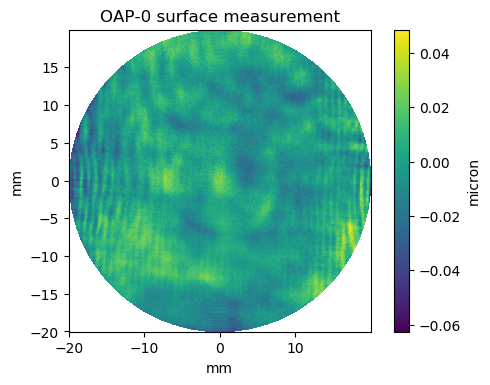

In [2]:
# For a lot of common values, I use a dictionary to define things.
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.05*u.m, #50*u.mm, # not really useful but legacy
             'label': 'OAP-0',
             'surf_unit': u.micron, # pre-known
             'ring_width': 5,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

filename_prefix = 'data/oap0_centered_80CA'
mask_data = fits.open(filename_prefix+'_mask.fits')[0].data
surf_hdu = fits.open(filename_prefix+'_surf.fits')[0]

# data pulled the header
surf_data = surf_hdu.data * opt_parms['surf_unit']
opt_parms['latres'] = surf_hdu.header['latres']*u.m
opt_parms['diam_ca'] = surf_hdu.header['diam_ca']*u.mm

# show the surface
dfx.show_image(data=dfx.sn_map(surf_data.value, mask_data),
               data_unit = opt_parms['surf_unit'],
               pixscale = opt_parms['latres'].to(u.mm),
               fig_title="OAP-0 surface measurement")

The PSD code is written in an object oriented format with a bunch of different functions that should be followed at a particular sequence. But, they are simple and will be explained.

First, let's start with initializing and loading in the data.

In [3]:
# initialize the object
oap = psd.surfPSD(surf_name=opt_parms['label'])

# insert the surface from FITS file
oap.open_surf(fileloc=filename_prefix+'_surf.fits', 
              surf_units = opt_parms['surf_unit'])

# insert the mask file from FITS file
oap.open_mask(fileloc=filename_prefix+'_mask.fits')

Now that the data is loaded in, we can calculate the PSD. The PSD is calculated by applying a 2D Hann window onto the surface, then taking the modulus square of the FT. Other things are going on behind the curtain, but I caution against reading my spaghetti code.

The `calc_psd` code will also calculate the rms for the whole optic and at low, mid, and high spatial frequency regions.

**NOTE 1**: The `kmid_ll` and `khigh_ll` values are necessary to run `calc_psd`. If you don't have specific ranges for the low, mid, and high spatial frequency regions for RMS calculations, then you can put down something reasonable. Preferably, something larger than `1/opt_parms['diam_ca']` (this is `kmin`) and something smaller than `1/(2*opt_parms['latres']` (this is `kmax`). 

In `calc_psd`, these values are defaulted to `kmid_ll=0.1/u.mm` and `khigh_ll=1/u.mm`.

**NOTE 2**: If you want to change the units for your surface, you can adjust it with `var_unit`. The default setting is changing to nanometers. In this example, the data inserted is in micron but I want it in nanometers.

In [4]:
# calculate the 2D PSD, which will also calculate the rms values.
oap.calc_psd(oversamp=opt_parms['ovs'], 
             kmid_ll=opt_parms['kmid_ll'], 
             khigh_ll=opt_parms['khigh_ll'],
             var_unit = u.nm)

At this point, you've calculated the 2D PSD and the rms values. Let's look at them real quick.

In [5]:
print('rms_tot: {0:.3f}'.format(oap.rms_tot))
print('rms_low: {0:.3f}'.format(oap.rms_l))
print('rms_mid: {0:.3f}'.format(oap.rms_m))
print('rms_high: {0:.3f}'.format(oap.rms_h))

rms_tot: 10.239 nm
rms_low: 5.854 nm
rms_mid: 7.902 nm
rms_high: 2.849 nm


Text(0.5, 1.0, '2D PSD for OAP-0')

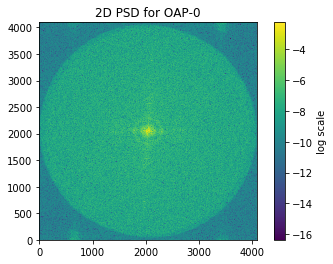

In [6]:
plt.imshow(np.log10(oap.psd_cal.value), origin='lower')
plt.colorbar().set_label('log scale')
plt.title('2D PSD for {0}'.format(opt_parms['label']))

While the 2D PSD is great, it's kind of useless to make anything out of it. What is more useful is to look at the radial analysis. Unfortunately, this is the slowest part of the PSD calculation, but hopefully you only need to run it once.

To speed things up, you can adjust the `opt_parms['ring_width']` parameter to a higher number, but don't go to far else you may start to lose features in the radial PSD. The code won't let you go lower than 3 and it must always be an odd number.

In [7]:
%%time
oap.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=oap.k_min)

CPU times: user 2min 32s, sys: 58.9 s, total: 3min 31s
Wall time: 3min 31s


Text(0.5, 1.0, 'Radial PSD for OAP-0')

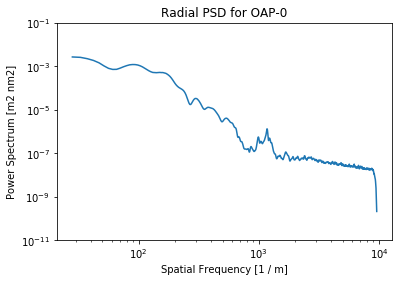

In [8]:
plt.loglog(oap.k_radial.value, oap.psd_radial_cal.value, 
           label='Radial PSD')
plt.xlabel('Spatial Frequency [{0}]'.format(oap.k_radial.unit))
plt.ylabel('Power Spectrum [{0}]'.format(oap.psd_radial_cal.unit))
plt.ylim(top=1e-1, bottom=1e-11)
plt.title('Radial PSD for {0}'.format(opt_parms['label']))

**NOTE ON PSD UNITS**: They don't sound intuitive, but I'll do my best to explain how I got them.

In the spatial domain, the surface units are in nm. The pixel sides are scaled in m.

When you go to the spatial frequency domain with the FFT, your FT-surface units are still in nm. But now your pixels are scaled in 1/m.

When you take the power (`|FT(surf)|^2`), the value at each pixel is now nm^2. The pixel resolution is still 1/m.

To understand the PSD units, think of the volume of each pixel. The height is nm^2 and each side of the pixel is in 1/mm. The PSD is the power of the surface per pixel area, which makes it nm^2 / (1/m) x (1/m) = nm^2 / (1/m^2) = nm^2 m^2.